In [1]:
import numpy as np
import tensorflow as tf
import seaborn as sns
from keras.datasets import mnist

### Loading the MNIST Dataset

In [2]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [3]:
X_train = X_train.reshape(-1, 784).T / 255.0
X_test  = X_test.reshape(-1, 784).T  / 255.0
Y_train = tf.keras.utils.to_categorical(Y_train).T
Y_test  = tf.keras.utils.to_categorical(Y_test).T

In [4]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((784, 60000), (10, 60000), (784, 10000), (10, 10000))

### Initializing the Neural Network

In [5]:
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

class NeuralNetwork:
    def __init__(self, layer_sizes):
        self.weights = [ np.random.randn(out, layer_sizes[idx]) / np.sqrt(2 * layer_sizes[idx]) for idx, out in enumerate(layer_sizes[1:]) ]
        self.biases  = [ np.zeros((n_bias, 1)) for n_bias in layer_sizes[1:] ]
        
    def predict(self, X):
        a_out = X
        for idx, (W, b) in enumerate(zip(self.weights, self.biases)):
            z_out = np.dot(W, a_out) + b

            if idx < len(self.weights) - 1:
                a_out = np.maximum(0, z_out)
            else:
                a_out = np.exp(z_out) / np.sum(np.exp(z_out), axis = 0)
        return a_out
        
    def fit(self, X, Y, n_epochs, learning_rate):
        loss_hist = []
        accs_hist = []
        
        for epoch in range(n_epochs):
            z_outs = [ X ]
            a_outs = [ X ] # A_0 is the input layer
            batch_size = X.shape[1]

            # Forward pass
            for idx, (W, b) in enumerate(zip(self.weights, self.biases)):
                z_out = np.dot(W, a_outs[-1]) + b
                
                if idx < len(self.weights) - 1:
                    a_out = np.maximum(0, z_out)
                else:
                    a_out = np.exp(z_out) / np.sum(np.exp(z_out), axis = 0)
                    
                z_outs.append(z_out)
                a_outs.append(a_out)

            # Compute loss/cost
            acc  = np.average(np.argmax(a_outs[-1], axis = 0) == np.argmax(Y, axis = 0))
            loss = np.sum(-(Y * np.log(a_outs[-1]) + (1 - Y) * np.log(1 - a_outs[-1])), axis = 0, keepdims = True)
            cost = np.average(loss)
            loss_hist.append(cost)
            accs_hist.append(acc)
            print('[epoch {:2}/{:2}] - cost: {:.4f} - accuracy: {:.4f}'.format(epoch + 1, n_epochs, cost, acc))

            # Backpropagation
            d_weights = []
            d_biases  = []

            # Assumes softmax output layer for multiclass classification
            grad_Zs   = [ a_outs[-1] - Y ]

            for (W, b, A, Z) in zip(self.weights[::-1], self.biases[::-1], a_outs[::-1][1:], z_outs[::-1][1:]):
                grad_Z   = grad_Zs[-1]
                d_weight = np.dot(grad_Z, A.T) / batch_size
                d_bias   = np.sum(grad_Z, axis = 1, keepdims = True) / batch_size

                # Gradients w.r.t to Z of the next layer backwards
                grad_Zn  = np.dot(W.T, grad_Z) * (Z > 0.0)
                #print(d_weight.shape, d_bias.shape, grad_Zn.shape)
                grad_Zs.append(grad_Zn)
                d_weights.insert(0, d_weight)
                d_biases.insert(0, d_bias)

            # Update step
            for idx, (dW, db) in enumerate(zip(d_weights, d_biases)):
                self.weights[idx] -= learning_rate * dW
                self.biases[idx]  -= learning_rate * db
                #print(dW, db)
                
        return loss_hist, accs_hist

In [6]:
mnist_nn  = NeuralNetwork(layer_sizes = [784, 300, 10])
loss, acc = mnist_nn.fit(X_train, Y_train, n_epochs = 50, learning_rate = 0.25)

[epoch  1/50] - cost: 3.2588 - accuracy: 0.0838
[epoch  2/50] - cost: 3.1756 - accuracy: 0.3471
[epoch  3/50] - cost: 3.0968 - accuracy: 0.5342
[epoch  4/50] - cost: 3.0150 - accuracy: 0.6109
[epoch  5/50] - cost: 2.9268 - accuracy: 0.6553
[epoch  6/50] - cost: 2.8312 - accuracy: 0.6848
[epoch  7/50] - cost: 2.7286 - accuracy: 0.7058
[epoch  8/50] - cost: 2.6201 - accuracy: 0.7212
[epoch  9/50] - cost: 2.5075 - accuracy: 0.7332
[epoch 10/50] - cost: 2.3926 - accuracy: 0.7418
[epoch 11/50] - cost: 2.2778 - accuracy: 0.7508
[epoch 12/50] - cost: 2.1654 - accuracy: 0.7609
[epoch 13/50] - cost: 2.0575 - accuracy: 0.7694
[epoch 14/50] - cost: 1.9556 - accuracy: 0.7780
[epoch 15/50] - cost: 1.8607 - accuracy: 0.7864
[epoch 16/50] - cost: 1.7730 - accuracy: 0.7944
[epoch 17/50] - cost: 1.6928 - accuracy: 0.8012
[epoch 18/50] - cost: 1.6196 - accuracy: 0.8076
[epoch 19/50] - cost: 1.5530 - accuracy: 0.8138
[epoch 20/50] - cost: 1.4926 - accuracy: 0.8191
[epoch 21/50] - cost: 1.4376 - accuracy:

<AxesSubplot:>

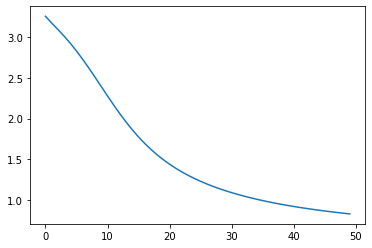

In [7]:
sns.lineplot(x = np.arange(len(loss)), y = loss)

<AxesSubplot:>

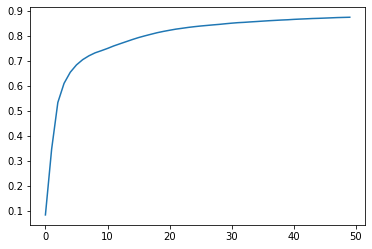

In [8]:
sns.lineplot(x = np.arange(len(acc)), y = acc)

In [9]:
# Evaluate on the test dataset
Y_pred   = mnist_nn.predict(X_test)
test_acc = np.average(np.argmax(Y_pred, axis = 0) == np.argmax(Y_test, axis = 0))
print('Test accuracy: {:.4f}'.format(test_acc))

Test accuracy: 0.8830
